In [2]:
#Importing Libraries
import pandas as pd
import numpy as np
import gensim
from gensim import corpora, models
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from pprint import pprint
np.random.seed(2018)
import nltk
import re
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis
import os
import tqdm
import warnings
#nltk.download('wordnet')#if it is already downloaded just import nltk
stemmer = SnowballStemmer('english')
warnings.filterwarnings('ignore')


In [3]:
#Loading the Dataset
df = pd.read_csv(r"C:\Users\Ayush\hydrogen fuel data.csv",low_memory=False)
df["Result"] = df['Message'].astype(str) +"-"+ df["Link Text"].astype(str) + "-" + df['Image Text']

In [4]:
data_text = df[['Result']]
data_text['index'] = data_text.index
documents = data_text

In [5]:
#Preprocessing of the DataFrame
#Reducing text to its initial lemma
#removing stopwords
#removing emojis
#avoiding text which is shorter than 3 words
#Transforming text into Lowercase
unrelatedwords=['hydrogen','https','energy','fuel','fuels','energies','fuelled','fuelling']

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            if token not in unrelatedwords:
                result.append(lemmatize_stemming(token))
    return result


def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F" # emoticons
                           u"\U0001F300-\U0001F5FF" # symbols & pictographs
                           u"\U0001F680-\U0001F6FF" # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF" # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(text)


In [6]:
documents['Result'] = documents['Result'].astype(str)
#preprocessing the dataset
processed_docs = documents['Result'].map(preprocess)
print(processed_docs[:10])

0                                                   []
1                                                   []
2                                                   []
3    [acwa, power, develop, investor, oper, power, ...
4                                                   []
5                                                   []
6                                                   []
7                                                   []
8                                                   []
9                                                   []
Name: Result, dtype: object


In [7]:
#Creating a dictionary from ‘processed_docs’ which contains the number of times a word appears in the training set.
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 acwa
1 announc
2 arabia
3 ceremoni
4 compani
5 decarbon
6 desalin
7 develop
8 digit
9 drive
10 establish


In [8]:
#Filtering out the dictionary and only keeping the first 100000 most frequent tokens.
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

In [9]:
#For each document we create a dictionary
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
print(bow_corpus[4310])

[]


In [10]:
#Previewing the Bag Of Words for our sample preprocessed document.
bow_doc_4310 = bow_corpus[4310]

for i in range(len(bow_doc_4310)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_4310[i][0], 
                                                     dictionary[bow_doc_4310[i][0]], 
                                                     bow_doc_4310[i][1]))


In [11]:
#creatin a tifdif model on bow_corpus
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
for doc in corpus_tfidf:
    pprint(doc)
    break

[]


In [12]:
#Establishing The Lda Model.
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=2)

In [13]:
#For each topic, we will explore the words occuring in that topic and its relative weight.
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.016*"photo" + 0.013*"bubbl" + 0.012*"gastech" + 0.011*"skin" + 0.010*"alga" + 0.010*"furbi" + 0.009*"power" + 0.009*"come" + 0.009*"book" + 0.008*"petopia"
Topic: 1 
Words: 0.015*"water" + 0.013*"power" + 0.013*"need" + 0.011*"nuclear" + 0.009*"engin" + 0.007*"fusion" + 0.007*"sourc" + 0.007*"upskil" + 0.007*"alarm" + 0.006*"aviat"
Topic: 2 
Words: 0.028*"power" + 0.020*"green" + 0.013*"renew" + 0.012*"africa" + 0.011*"industri" + 0.010*"technolog" + 0.009*"project" + 0.009*"product" + 0.009*"futur" + 0.009*"carbon"
Topic: 3 
Words: 0.036*"electr" + 0.033*"cell" + 0.031*"vehicl" + 0.031*"power" + 0.011*"batteri" + 0.010*"emiss" + 0.010*"develop" + 0.009*"technolog" + 0.009*"photo" + 0.008*"hybrid"
Topic: 4 
Words: 0.014*"water" + 0.013*"product" + 0.013*"skin" + 0.012*"power" + 0.011*"toubro" + 0.011*"larsen" + 0.011*"indianoil" + 0.010*"teri" + 0.010*"process" + 0.009*"photo"
Topic: 5 
Words: 0.024*"say" + 0.021*"green" + 0.014*"power" + 0.013*"countri" + 0.012*"min

In [14]:
#Running LDA using TF-IDF
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.010*"toyota" + 0.009*"vehicl" + 0.008*"power" + 0.008*"electr" + 0.008*"labour" + 0.007*"year" + 0.007*"nuclear" + 0.006*"car" + 0.006*"cell" + 0.005*"million"
Topic: 1 Word: 0.010*"electr" + 0.010*"power" + 0.008*"cell" + 0.006*"ammonia" + 0.006*"pari" + 0.006*"hyundai" + 0.005*"water" + 0.005*"fusion" + 0.005*"hybrid" + 0.005*"green"
Topic: 2 Word: 0.024*"india" + 0.017*"brief" + 0.013*"wood" + 0.012*"power" + 0.011*"regist" + 0.010*"renew" + 0.009*"mackenzi" + 0.009*"ministri" + 0.008*"event" + 0.007*"green"
Topic: 3 Word: 0.014*"skin" + 0.009*"bubbl" + 0.008*"photo" + 0.008*"alga" + 0.008*"furbi" + 0.008*"power" + 0.007*"style" + 0.006*"petopia" + 0.005*"therapi" + 0.005*"seawe"
Topic: 4 Word: 0.010*"power" + 0.008*"green" + 0.005*"india" + 0.005*"technolog" + 0.005*"electr" + 0.005*"industri" + 0.005*"renew" + 0.005*"sustain" + 0.005*"futur" + 0.004*"project"
Topic: 5 Word: 0.024*"norway" + 0.020*"india" + 0.015*"summit" + 0.015*"greenstat" + 0.013*"kreston" + 0.0

In [15]:
#Performance evaluation by classifying sample document using LDA Bag of Words model.
for index, score in sorted(lda_model[bow_corpus[4310]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


Score: 0.10000000149011612	 
Topic: 0.016*"photo" + 0.013*"bubbl" + 0.012*"gastech" + 0.011*"skin" + 0.010*"alga" + 0.010*"furbi" + 0.009*"power" + 0.009*"come" + 0.009*"book" + 0.008*"petopia"

Score: 0.10000000149011612	 
Topic: 0.015*"water" + 0.013*"power" + 0.013*"need" + 0.011*"nuclear" + 0.009*"engin" + 0.007*"fusion" + 0.007*"sourc" + 0.007*"upskil" + 0.007*"alarm" + 0.006*"aviat"

Score: 0.10000000149011612	 
Topic: 0.028*"power" + 0.020*"green" + 0.013*"renew" + 0.012*"africa" + 0.011*"industri" + 0.010*"technolog" + 0.009*"project" + 0.009*"product" + 0.009*"futur" + 0.009*"carbon"

Score: 0.10000000149011612	 
Topic: 0.036*"electr" + 0.033*"cell" + 0.031*"vehicl" + 0.031*"power" + 0.011*"batteri" + 0.010*"emiss" + 0.010*"develop" + 0.009*"technolog" + 0.009*"photo" + 0.008*"hybrid"

Score: 0.10000000149011612	 
Topic: 0.014*"water" + 0.013*"product" + 0.013*"skin" + 0.012*"power" + 0.011*"toubro" + 0.011*"larsen" + 0.011*"indianoil" + 0.010*"teri" + 0.010*"process" + 0.009

In [16]:
#Performance evaluation by classifying sample document using LDA TF-IDF model.
for index, score in sorted(lda_model_tfidf[bow_corpus[4310]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))


Score: 0.10000000149011612	 
Topic: 0.010*"toyota" + 0.009*"vehicl" + 0.008*"power" + 0.008*"electr" + 0.008*"labour" + 0.007*"year" + 0.007*"nuclear" + 0.006*"car" + 0.006*"cell" + 0.005*"million"

Score: 0.10000000149011612	 
Topic: 0.010*"electr" + 0.010*"power" + 0.008*"cell" + 0.006*"ammonia" + 0.006*"pari" + 0.006*"hyundai" + 0.005*"water" + 0.005*"fusion" + 0.005*"hybrid" + 0.005*"green"

Score: 0.10000000149011612	 
Topic: 0.024*"india" + 0.017*"brief" + 0.013*"wood" + 0.012*"power" + 0.011*"regist" + 0.010*"renew" + 0.009*"mackenzi" + 0.009*"ministri" + 0.008*"event" + 0.007*"green"

Score: 0.10000000149011612	 
Topic: 0.014*"skin" + 0.009*"bubbl" + 0.008*"photo" + 0.008*"alga" + 0.008*"furbi" + 0.008*"power" + 0.007*"style" + 0.006*"petopia" + 0.005*"therapi" + 0.005*"seawe"

Score: 0.10000000149011612	 
Topic: 0.010*"power" + 0.008*"green" + 0.005*"india" + 0.005*"technolog" + 0.005*"electr" + 0.005*"industri" + 0.005*"renew" + 0.005*"sustain" + 0.005*"futur" + 0.004*"proje

In [17]:
#Testing model on unseen document
unseen_document = input()
bow_vector = dictionary.doc2bow(preprocess(unseen_document))

for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))

4
Score: 0.10000000149011612	 Topic: 0.016*"photo" + 0.013*"bubbl" + 0.012*"gastech" + 0.011*"skin" + 0.010*"alga"
Score: 0.10000000149011612	 Topic: 0.015*"water" + 0.013*"power" + 0.013*"need" + 0.011*"nuclear" + 0.009*"engin"
Score: 0.10000000149011612	 Topic: 0.028*"power" + 0.020*"green" + 0.013*"renew" + 0.012*"africa" + 0.011*"industri"
Score: 0.10000000149011612	 Topic: 0.036*"electr" + 0.033*"cell" + 0.031*"vehicl" + 0.031*"power" + 0.011*"batteri"
Score: 0.10000000149011612	 Topic: 0.014*"water" + 0.013*"product" + 0.013*"skin" + 0.012*"power" + 0.011*"toubro"
Score: 0.10000000149011612	 Topic: 0.024*"say" + 0.021*"green" + 0.014*"power" + 0.013*"countri" + 0.012*"minist"
Score: 0.10000000149011612	 Topic: 0.017*"launch" + 0.013*"nasa" + 0.012*"rocket" + 0.010*"space" + 0.008*"moon"
Score: 0.10000000149011612	 Topic: 0.013*"clean" + 0.012*"power" + 0.010*"industri" + 0.009*"carbon" + 0.009*"futur"
Score: 0.10000000149011612	 Topic: 0.044*"india" + 0.017*"power" + 0.017*"summi

In [18]:
#Using c_v measure
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs,dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)


Coherence Score:  0.48426781141184955


In [19]:
coherence_model_TFIDF = CoherenceModel(model=lda_model_tfidf,texts=processed_docs,coherence='c_v')
coherence_model_TFIDF = coherence_model_TFIDF.get_coherence()
print('coherence Score:',coherence_model_TFIDF)

coherence Score: 0.45570470964344184


In [20]:
#Hyperparameter Tuning
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [ ]:
import tqdm

grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(bow_corpus)
corpus_sets = [gensim.utils.ClippedCorpus(bow_corpus, int(num_of_docs*0.75)), 
               bow_corpus]

corpus_title = ['75% Corpus', '100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# Can take a long time to run
if True:
    pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=dictionary, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv(r'C:\Users\Ayush\Github\clone\LDA-topic-modelling\lda_tuning_results.csv', index=False)
    pbar.close()


Coherence Score:  [0.8416136703405416, 0.248660073316708, 0.5217773425914058, 0.4881241789156293, 0.23815976036066813, 0.5080068529966939, 0.48247348887432295, 0.4918906977568292, 0.6444102053503864, 0.3775618436153103]


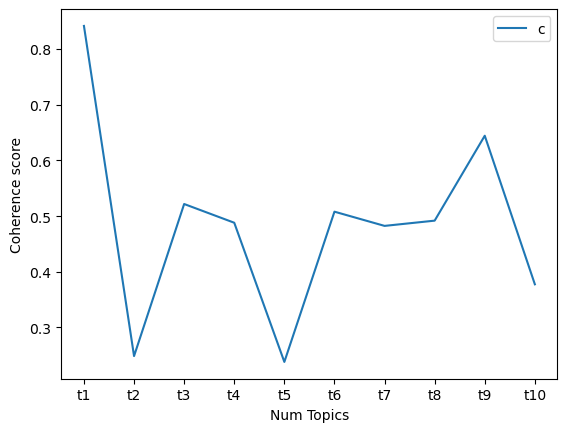

In [21]:
# Compute Coherence Score using c_v
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
coherence_ldas = coherence_model_lda.get_coherence_per_topic()
print('\nCoherence Score: ', coherence_ldas)

import matplotlib.pyplot as plt
import numpy as np
topicsname=[]
for i in range(1,11):
    topicsname.append("t{0}".format(i))
topicsname

plt.plot(topicsname,coherence_ldas)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [28]:
def compute_coherence_values(dictionary,bow_corpus, processed_docs, limit, start=1, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=gensim.models.LdaMulticore(corpus=bow_corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

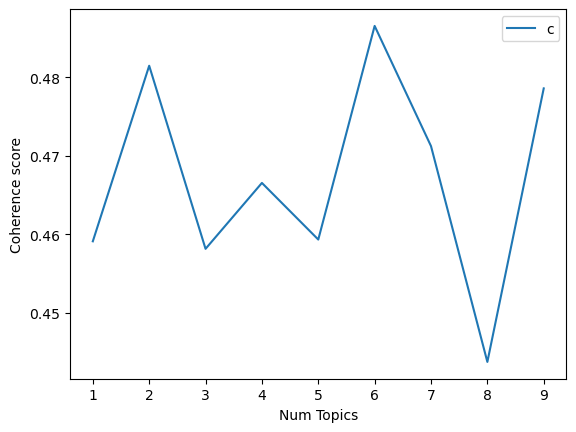

In [29]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, bow_corpus=bow_corpus, processed_docs=processed_docs, start=1, limit=10, step=1)
# Show graph
import matplotlib.pyplot as plt
limit=10; start=1; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

Both of the Coherence measures are depicting the optimal number of topics to be 6.

In [31]:
#Final LDA Model
lda_model = gensim.models.LdaMulticore(corpus=bow_corpus,
                                           id2word=dictionary,
                                           num_topics=6, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.01,
                                           eta=0.9)


In [32]:
#Viewing the top words in the Topics
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.030*"green" + 0.024*"power" + 0.014*"plant" + 0.013*"renew" + 0.013*"say" + 0.013*"project" + 0.012*"develop" + 0.011*"india" + 0.009*"nuclear" + 0.008*"countri"
Topic: 1 
Words: 0.021*"electr" + 0.019*"power" + 0.017*"vehicl" + 0.015*"cell" + 0.014*"emiss" + 0.012*"technolog" + 0.009*"zero" + 0.009*"carbon" + 0.008*"engin" + 0.008*"futur"
Topic: 2 
Words: 0.026*"india" + 0.021*"power" + 0.014*"industri" + 0.014*"renew" + 0.014*"regist" + 0.013*"event" + 0.011*"summit" + 0.011*"green" + 0.010*"intern" + 0.010*"confer"
Topic: 3 
Words: 0.020*"launch" + 0.020*"drive" + 0.019*"nasa" + 0.018*"carcinogen" + 0.018*"toxic" + 0.017*"rocket" + 0.015*"space" + 0.012*"moon" + 0.010*"flight" + 0.009*"island"
Topic: 4 
Words: 0.011*"power" + 0.009*"year" + 0.008*"state" + 0.007*"govern" + 0.007*"plan" + 0.007*"climat" + 0.006*"support" + 0.006*"clean" + 0.006*"renew" + 0.006*"say"
Topic: 5 
Words: 0.017*"water" + 0.010*"power" + 0.008*"carbon" + 0.008*"photo" + 0.007*"engin" + 0.

In [33]:
# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join(r'C:\Users\Ayush\Github\clone\LDA-topic-modelling\lda_tuning_results.csv'+str(10))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if True:
    LDAvis_prepared = gensimvis.prepare(lda_model, bow_corpus, dictionary)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, r'C:\Users\Ayush\Github\clone\LDA-topic-modelling\lda_tuning_results.csv'+ str(10) +'.html')

LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.040128  0.039587       1        1  27.794654
4     -0.047532  0.040777       2        1  23.052783
0     -0.095144  0.033499       3        1  16.438701
2     -0.153811 -0.139156       4        1  14.322257
5      0.108468  0.170958       5        1  14.287049
3      0.228147 -0.145665       6        1   4.104555, topic_info=         Term         Freq        Total Category  logprob  loglift
157     india  1720.000000  1720.000000  Default  30.0000  30.0000
14      green  2816.000000  2816.000000  Default  29.0000  29.0000
189    vehicl  1638.000000  1638.000000  Default  28.0000  28.0000
8       drive   676.000000   676.000000  Default  27.0000  27.0000
111    electr  2251.000000  2251.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
777     event    71.104734   787.461093   Topic6  -5.1874   0.7884
112     engin    68.816305  1207.412021   Topic6  -5.2201   0.3283
2287    booth    61.714249   219.799198   Topic6  -5.3291   1.9229
178   univers    62.534176   409.187802   Topic6  -5.3159   1.3146
552     group    60.655132   492.511900   Topic6  -5.3464   1.0988

[416 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
2349      1  0.025629  acetaldehyd
2349      2  0.025629  acetaldehyd
2349      3  0.025629  acetaldehyd
2349      4  0.025629  acetaldehyd
2349      5  0.025629  acetaldehyd
...     ...       ...          ...
2315      2  0.045057         东福一号
2315      3  0.811027         东福一号
2315      4  0.045057         东福一号
2315      5  0.045057         东福一号
2315      6  0.045057         东福一号

[2034 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 1, 3, 6, 4])